In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import os
import tqdm

C:\Users\My-PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
train = pd.read_csv('sales_train.csv')
test = pd.read_csv('test.csv')

train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [3]:
# We have supplementary files that contain additional information about the items, item categories, and shops. Let's load them and take a look at the first few rows.
items = pd.read_csv('items.csv')
item_cats = pd.read_csv('item_categories.csv')
shops = pd.read_csv('shops.csv')

In [4]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [5]:
item_cats.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [6]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


## Data Wrangling

In [7]:
# The item categories file contains the category name in Russian. We can extract the main category and subcategory from the category name.
item_cats['split'] = item_cats['item_category_name'].str.split('-')

item_cats['type'] = item_cats['split'].map(lambda x: x[0].strip())
item_cats['subtype'] = item_cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())

item_cats = item_cats[['item_category_id','type','subtype']]
item_cats.head()

,item_category_id,type,subtype
0,0,PC,Гарнитуры/Наушники
1,1,Аксессуары,PS2
2,2,Аксессуары,PS3
3,3,Аксессуары,PS4
4,4,Аксессуары,PSP


In [8]:
# Shops file contains the city name in Russian. We can extract the city name and the shop name.
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.head()

,shop_name,shop_id,city
0,"!Якутск Орджоникидзе, 56 фран",0,!Якутск
1,"!Якутск ТЦ ""Центральный"" фран",1,!Якутск
2,"Адыгея ТЦ ""Мега""",2,Адыгея
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха
4,"Волжский ТЦ ""Волга Молл""",4,Волжский


In [9]:
# Check for missing values
train.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

In [10]:
# Check for duplicates
train.duplicated().sum()

6

In [11]:
# Remove duplicates
train.drop_duplicates(inplace=True)

In [12]:
# Check for unique values and drop the rows with negative item price and sales

for col in train.columns:
    print(col, train[col].nunique())

train = train[train.item_price > 0] # Checks for negative values
train = train[train.item_cnt_day > 0] # checks for negative values

date 1034
date_block_num 34
shop_id 60
item_id 21807
item_price 19993
item_cnt_day 198


In [13]:
# Drop columns with only one unique value as they do not provide any information
for col in train.columns:
    if train[col].nunique() == 1:
        print(col)
        train.drop(col, axis = 1, inplace = True)

In [14]:
# check for nuniques values in shops, items and item_cats
for col in shops.columns:
    print(col, shops[col].nunique())

print("-----------------")

for col in items.columns:
    print(col, items[col].nunique())

print("-----------------")

for col in item_cats.columns:
    print(col, item_cats[col].nunique())

shop_name 60
shop_id 60
city 32
-----------------
item_name 22170
item_id 22170
item_category_id 84
-----------------
item_category_id 84
type 20
subtype 65


In [15]:
# Check for missing values in shops, items and item_cats
print(shops.isnull().sum())
print("-----------------")
print(items.isnull().sum())
print("-----------------")
print(item_cats.isnull().sum())

shop_name    0
shop_id      0
city         0
dtype: int64
-----------------
item_name           0
item_id             0
item_category_id    0
dtype: int64
-----------------
item_category_id    0
type                0
subtype             0
dtype: int64


In [16]:
# Merge the train data with the supplementary files
train = train.merge(items, on = 'item_id', how = 'left')
train = train.merge(item_cats, on = 'item_category_id', how = 'left')
train = train.merge(shops, on = 'shop_id', how = 'left')

train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,type,subtype,shop_name,city
0,02.01.2013,0,59,22154,999.00,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино,Blu,"Ярославль ТЦ ""Альтаир""",Ярославль
1,03.01.2013,0,25,2552,899.00,1.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка,Винил,"Москва ТРК ""Атриум""",Москва
2,06.01.2013,0,25,2554,1709.05,1.0,DEEP PURPLE Who Do You Think We Are LP,58,Музыка,Винил,"Москва ТРК ""Атриум""",Москва
3,15.01.2013,0,25,2555,1099.00,1.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка,CD фирменного производства,"Москва ТРК ""Атриум""",Москва
4,10.01.2013,0,25,2564,349.00,1.0,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,Музыка,Музыкальное видео,"Москва ТРК ""Атриум""",Москва


In [17]:
# Check for missing values
train.isnull().sum()

date                0
date_block_num      0
shop_id             0
item_id             0
item_price          0
item_cnt_day        0
item_name           0
item_category_id    0
type                0
subtype             0
shop_name           0
city                0
dtype: int64

In [18]:
# Check for duplicates
train.duplicated().sum()

0

In [19]:
print("Our data has {} samples and {} features".format(train.shape[0], train.shape[1]))
# Where samples are the rows and features are the columns

Our data has 2928486 samples and 12 features


In [20]:
train['date'] = pd.to_datetime(train['date'], format = '%d.%m.%Y')

# Extract the month, year, and day of the week from the date column
train['month'] = train['date'].dt.month
train['year'] = train['date'].dt.year
train['dow'] = train['date'].dt.dayofweek

# Aggregate the data to the monthly level
monthly_sales = train.groupby(['shop_id', 'item_id', 'date_block_num', 'item_price'], as_index = False).agg({'item_cnt_day':'sum'})
monthly_sales = monthly_sales.rename(columns = {'item_cnt_day':'item_cnt_month'})
monthly_sales['revenue'] = monthly_sales['item_cnt_month'] * monthly_sales['item_price']

monthly_sales.head()

,shop_id,item_id,date_block_num,item_price,item_cnt_month,revenue
0,0,30,1,265.0,31.0,8215.0
1,0,31,1,434.0,11.0,4774.0
2,0,32,0,221.0,6.0,1326.0
3,0,32,1,221.0,10.0,2210.0
4,0,33,0,347.0,3.0,1041.0


In [21]:
# Check for missing values
monthly_sales.isnull().sum()

shop_id           0
item_id           0
date_block_num    0
item_price        0
item_cnt_month    0
revenue           0
dtype: int64

In [22]:
# Check for duplicates
monthly_sales.duplicated().sum()

0

In [23]:
# Check for unique values
for col in monthly_sales.columns:
    print(col, monthly_sales[col].nunique())

shop_id 60
item_id 21804
date_block_num 34
item_price 19977
item_cnt_month 415
revenue 28095


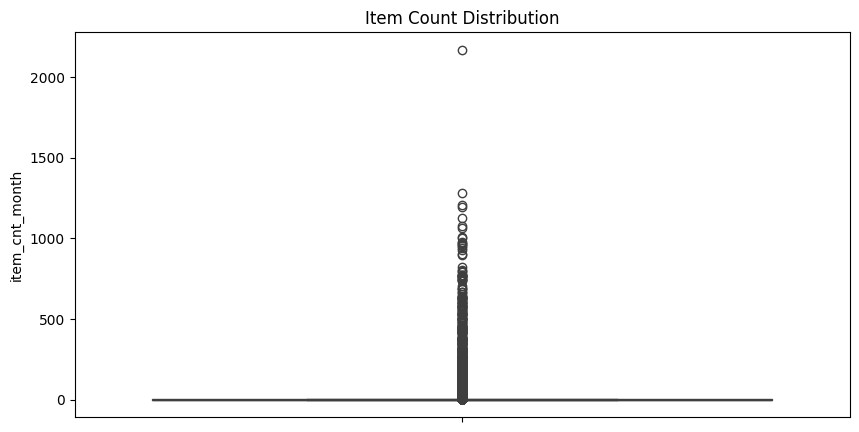

In [24]:
# Check for outliers
plt.figure(figsize = (10, 5))
sns.boxplot(monthly_sales['item_cnt_month'])
plt.title('Item Count Distribution')
plt.show();

In [25]:
# Deal with outliers
monthly_sales = monthly_sales[monthly_sales['item_cnt_month'] < 1000] # Remove outliers

## Feature Engineering

In [26]:
# We will use our monthly sales data to create features for our model. We will create the following features:
# 1. Lag features
# 2. Mean encoding features
# 3. Price trend features
# 4. Shop mean encoding features
# 5. Item mean encoding features
# 6. Item category mean encoding features
# 7. Shop item mean encoding features
# 8. Shop item category mean encoding features
# 9. Shop type mean encoding features
# 10. Shop subtype mean encoding features
# 11. Item type mean encoding features
# 12. Item subtype mean encoding features

# Create lag features
def create_lag_features(df, lags, col):
    for lag in lags:
        df[f'{col}_lag_{lag}'] = df.groupby(['shop_id', 'item_id'])[col].shift(lag)
    return df

monthly_sales = create_lag_features(monthly_sales, [1, 2, 3, 6, 12], 'item_cnt_month')

# Create mean encoding features
def create_mean_encoding_features(df, by, on):
    mean = df.groupby(by)[on].mean()
    df = df.join(mean, on = by, rsuffix = '_mean')
    return df

monthly_sales = create_mean_encoding_features(monthly_sales, ['date_block_num'], 'item_cnt_month')
monthly_sales = create_mean_encoding_features(monthly_sales, ['date_block_num'], 'revenue')
monthly_sales = create_mean_encoding_features(monthly_sales, ['shop_id'], 'item_cnt_month')
monthly_sales = create_mean_encoding_features(monthly_sales, ['item_id'], 'item_cnt_month')

# Create price trend features
def create_price_trend_features(df, by):
    df[f'price_trend_{by}'] = df.groupby([by])['item_price'].pct_change()
    return df

monthly_sales = create_price_trend_features(monthly_sales, 'item_id')
monthly_sales = create_price_trend_features(monthly_sales, 'shop_id')

# Remove duplicates if they exist
monthly_sales = monthly_sales.loc[:, ~monthly_sales.columns.duplicated()]

# Read full data
pd.set_option('display.max_columns', None)
monthly_sales.head()

,shop_id,item_id,date_block_num,item_price,item_cnt_month,revenue,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,item_cnt_month_mean,revenue_mean,price_trend_item_id,price_trend_shop_id
0,0,30,1,265.0,31.0,8215.0,NaN,NaN,NaN,NaN,NaN,1.968777,1394.968349,NaN,NaN
1,0,31,1,434.0,11.0,4774.0,NaN,NaN,NaN,NaN,NaN,1.968777,1394.968349,NaN,0.637736
2,0,32,0,221.0,6.0,1326.0,NaN,NaN,NaN,NaN,NaN,1.966633,1378.204193,NaN,-0.490783
3,0,32,1,221.0,10.0,2210.0,6.0,NaN,NaN,NaN,NaN,1.968777,1394.968349,0.0,0.000000
4,0,33,0,347.0,3.0,1041.0,NaN,NaN,NaN,NaN,NaN,1.966633,1378.204193,NaN,0.570136


In [27]:
# Check for missing values
monthly_sales.isnull().sum()

shop_id                        0
item_id                        0
date_block_num                 0
item_price                     0
item_cnt_month                 0
revenue                        0
item_cnt_month_lag_1      424098
item_cnt_month_lag_2      703850
item_cnt_month_lag_3      904454
item_cnt_month_lag_6     1263008
item_cnt_month_lag_12    1546625
item_cnt_month_mean            0
revenue_mean                   0
price_trend_item_id        21804
price_trend_shop_id           60
dtype: int64

In [28]:
# Drop columns with more than 50% missing values
missing_values = monthly_sales.isnull().sum() / monthly_sales.shape[0]
missing_values = missing_values[missing_values > 0.5].index
monthly_sales.drop(missing_values, axis = 1, inplace = True)

# Fill missing values with the median
monthly_sales.fillna(monthly_sales.median(), inplace = True)

# Check for missing values
monthly_sales.isnull().any().sum()

0

In [29]:
# Check for duplicates
monthly_sales.duplicated().sum()

0

In [30]:
# Check for unique values
for col in monthly_sales.columns:
    print(col, monthly_sales[col].nunique())

shop_id 60
item_id 21804
date_block_num 34
item_price 19976
item_cnt_month 406
revenue 28089
item_cnt_month_lag_1 396
item_cnt_month_lag_2 385
item_cnt_month_mean 34
revenue_mean 34
price_trend_item_id 83078
price_trend_shop_id 99613


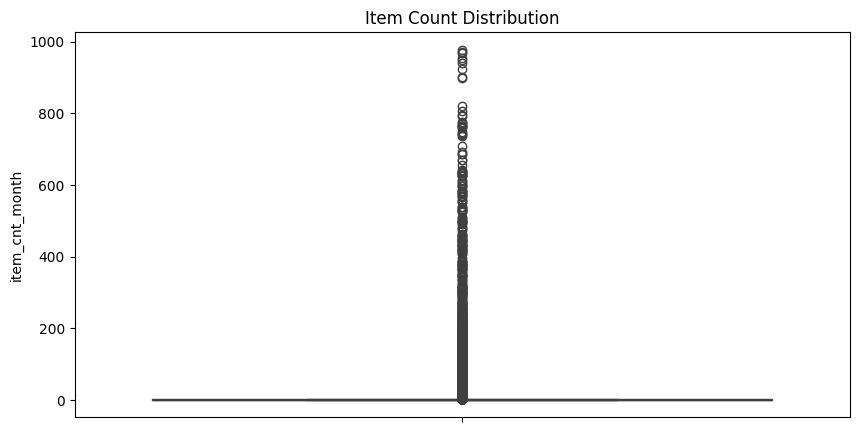

In [31]:
# Check for outliers
plt.figure(figsize = (10, 5))
sns.boxplot(monthly_sales['item_cnt_month'])
plt.title('Item Count Distribution')
plt.show();

In [ ]:
# We will our monthly sales as our training data and the test data as our test data. We will use the LightGBM model to make predictions.

In [32]:
# Merge the train and test data
test['date_block_num'] = 34
test = test.merge(items, on = 'item_id', how = 'left')
test = test.merge(item_cats, on = 'item_category_id', how = 'left')
test = test.merge(shops, on = 'shop_id', how = 'left')


In [33]:
# Check for missing values
test.isnull().sum()

ID                  0
shop_id             0
item_id             0
date_block_num      0
item_name           0
item_category_id    0
type                0
subtype             0
shop_name           0
city                0
dtype: int64

In [34]:
# Check for duplicates
test.duplicated().sum()

0

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.106787 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1376
[LightGBM] [Info] Number of data points in the train set: 1390284, number of used features: 9
[LightGBM] [Info] Start training from score 2.100888
RMSE: 3.8629169864635253


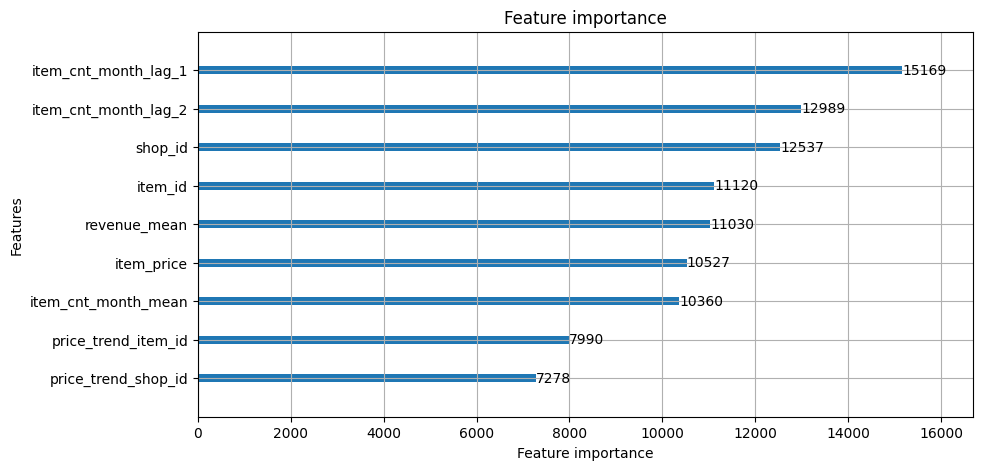

In [36]:
# Build our model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

# Define the features and target
features = [col for col in monthly_sales.columns if col not in ['item_cnt_month', 'revenue', 'date', 'date_block_num']]
target = 'item_cnt_month'

# Split the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(monthly_sales[features], monthly_sales[target], test_size = 0.2, random_state = 0)

# Create the LightGBM dataset
train_set = lgb.Dataset(X_train, y_train)
val_set = lgb.Dataset(X_val, y_val)

# Define the LightGBM parameters
params = {
    'objective':'regression',
    'metric':'rmse',
    'num_leaves': 100,
    'learning_rate': 0.1,
    'n_estimators': 1000,
    'max_bin': 255,
    'bagging_fraction': 0.75,
    'bagging_freq': 5,
    'bagging_seed': 7,
    'feature_fraction': 0.5,
    'feature_fraction_seed': 7,
    'verbose': 1
}

# Train the model
model = lgb.train(params, train_set, num_boost_round = 1000, valid_sets = [train_set, val_set])

# Make predictions
preds = model.predict(X_val)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_val, preds))
print(f'RMSE: {rmse}')

# Plot feature importance
lgb.plot_importance(model, figsize = (10, 5))
plt.show();

In [37]:
test.head()

,ID,shop_id,item_id,date_block_num,item_name,item_category_id,type,subtype,shop_name,city
0,0,5,5037,34,"NHL 15 [PS3, русские субтитры]",19,Игры,PS3,"Вологда ТРЦ ""Мармелад""",Вологда
1,1,5,5320,34,ONE DIRECTION Made In The A.M.,55,Музыка,CD локального производства,"Вологда ТРЦ ""Мармелад""",Вологда
2,2,5,5233,34,"Need for Speed Rivals (Essentials) [PS3, русск...",19,Игры,PS3,"Вологда ТРЦ ""Мармелад""",Вологда
3,3,5,5232,34,"Need for Speed Rivals (Classics) [Xbox 360, ру...",23,Игры,XBOX 360,"Вологда ТРЦ ""Мармелад""",Вологда
4,4,5,5268,34,"Need for Speed [PS4, русская версия]",20,Игры,PS4,"Вологда ТРЦ ""Мармелад""",Вологда


In [44]:
# Prediction on test set
missing_cols = [col for col in X_train.columns if col not in test.columns]

for col in missing_cols:

    test[col] = 0

test = test[X_train.columns]

# Make predictions
test_preds = model.predict(test)

# Create a submission file
sample = pd.read_csv("sample_submission.csv")
sample['item_cnt_month'] = test_preds
sample.to_csv("submission.csv", index = False)